In [1]:
import os 
import glob
from pathlib import Path
from rtmag.paper.parse import parse_tai_string
from sunpy.map import Map
import numpy as np
from skimage.transform import resize
from rtmag.paper.load import load_input_label, MyModel
import matplotlib.pyplot as plt
from streamtracer import StreamTracer, VectorGrid

In [2]:
data_path = "/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi"
hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z
data_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))

In [3]:
ix = 249
data_path = data_paths[ix]
data_path

('/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi/hmi.sharp_cea_720s.7115.20170906_090000_TAI.Bp.fits',
 '/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi/hmi.sharp_cea_720s.7115.20170906_090000_TAI.Bt.fits',
 '/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/12673/hmi/hmi.sharp_cea_720s.7115.20170906_090000_TAI.Br.fits')

In [16]:
Path(data_path[0]).name[-27:-12]

'20170906_090000'

In [4]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/12673")
len(input_files), len(label_files)

(389, 389)

In [5]:
idx = 241
input_files[idx], label_files[idx]

(PosixPath('/mnt/f/isee_dataset/12673/input/input_12673_20170906_090000.npz'),
 PosixPath('/mnt/f/isee_dataset/12673/label/label_12673_20170906_090000.npz'))

In [6]:
hmi_p, hmi_t, hmi_r, = data_paths[ix]
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [7]:
mm = MyModel("/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt")

Model loaded from epoch 75


In [8]:
b = mm.get_pred(input_files[idx])
B = mm.get_label(label_files[idx])
Bp = mm.get_pot(label_files[idx])
dx, dy, dz, dV = mm.get_dV(input_files[idx])
x, y, z = mm.get_coords(label_files[idx])

In [20]:
# tstr = Path(data_path[0]).name[23:38]
# obstime = parse_tai_string(tstr)
hmi_p, hmi_t, hmi_r, = data_path
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

# ox, oy, _ = hmi_data.shape
nx, ny = 512, 256

# l = 0.36 # Mm

# dx = (ox * l)/nx
# dy = (oy * l)/ny
# dz = dy 

# dx, dy, dz = dx * 1e8, dy * 1e8, dz * 1e8  # cm
# dV = dx * dy * dz # cm^3

model_input = resize(hmi_data, (nx, ny, 3))
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


(1, 1, 256, 512, 3)

In [21]:
b_sharp = mm.get_pred_from_numpy(model_input)

Model loaded from epoch 75


In [25]:
hmi_data.shape

(688, 448, 3)

In [26]:
model_input2 = hmi_data.transpose(1, 0, 2)[None, None, ...]
model_input2.shape

(1, 1, 448, 688, 3)

In [27]:
b_sharp2 = mm.get_pred_from_numpy(model_input2)

Model loaded from epoch 75


In [28]:
b_sharp2.shape

(688, 448, 256, 3)

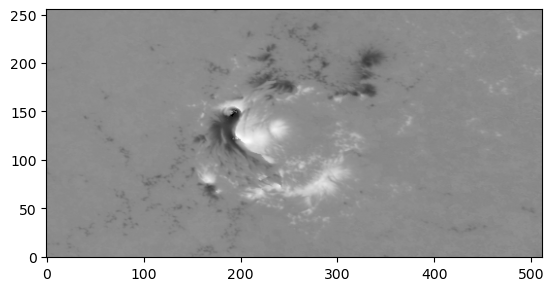

In [30]:
plt.imshow(b_sharp[:, :, 0, 2].T, origin='lower', cmap='gray')

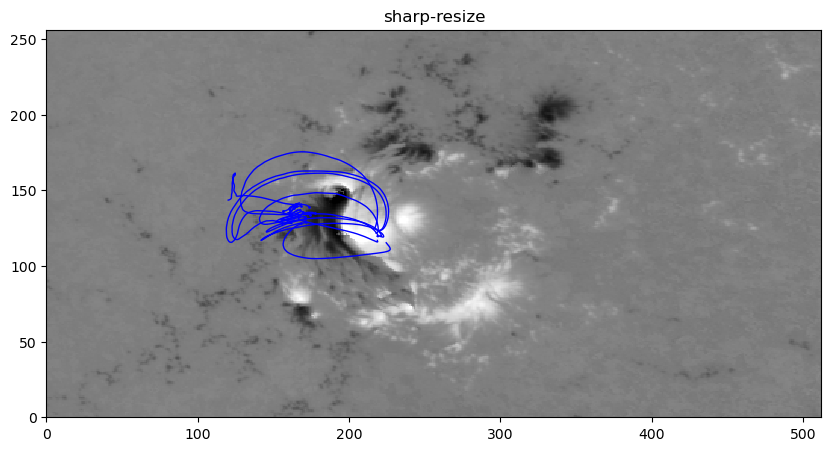

In [38]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = 512
Ly = 256
numbers = 20
# xmin, xmax, ymin, ymax
xyranges = [
    [0.30, 0.35, 0.50, 0.55],
]
grid_spacing = [1, 1, 1]

grid = VectorGrid(b_sharp, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]


seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b_sharp[..., 0, 2].T, cmap='gray', vmin=-2500, vmax=2500)
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("sharp-resize")
plt.show()

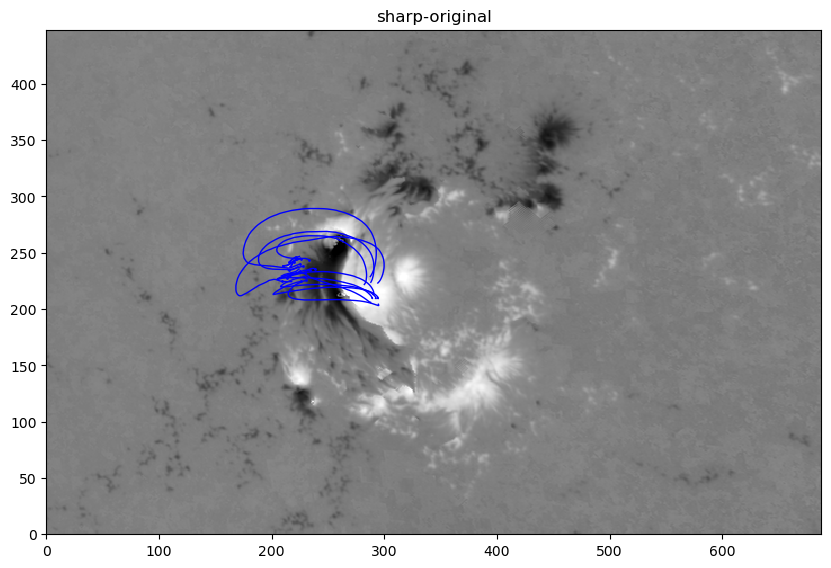

In [41]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = b_sharp2.shape[0]
Ly = b_sharp2.shape[1]
numbers = 20
# xmin, xmax, ymin, ymax
xyranges = [
    [0.30, 0.35, 0.50, 0.55],
]
grid_spacing = [1, 1, 1]

grid = VectorGrid(b_sharp2, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]


seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b_sharp2[..., 0, 2].T, cmap='gray', vmin=-2500, vmax=2500)
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("sharp-original")
plt.show()

In [14]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = 512
Ly = 256
numbers = 20
# xmin, xmax, ymin, ymax
xyranges = [
    [0.30, 0.35, 0.50, 0.55],
]
grid_spacing = [1, 1, 1]

grid = VectorGrid(b, grid_spacing)
grid_true = VectorGrid(B, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)
    tracer.trace(seeds, grid_true)
    tracer_xs_true.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]
tracer_xs_true = [item for sublist in tracer_xs_true for item in sublist]

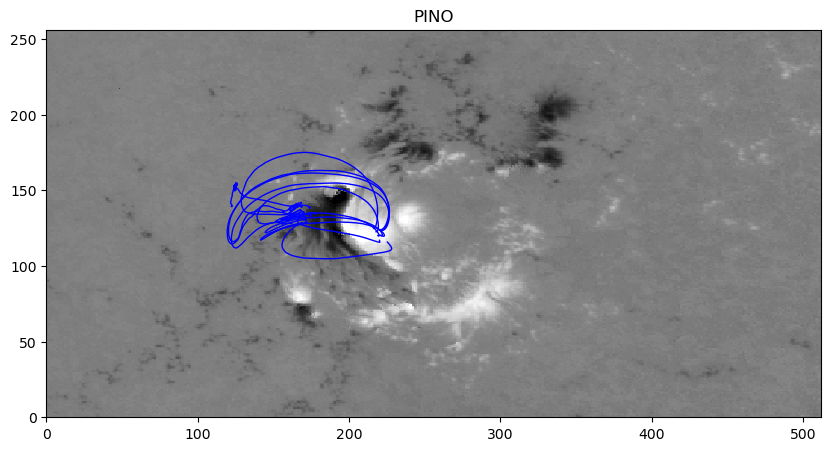

In [19]:
seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b[..., 0, 2].T, cmap='gray', vmin=-2500, vmax=2500)
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("PINO")
plt.show()

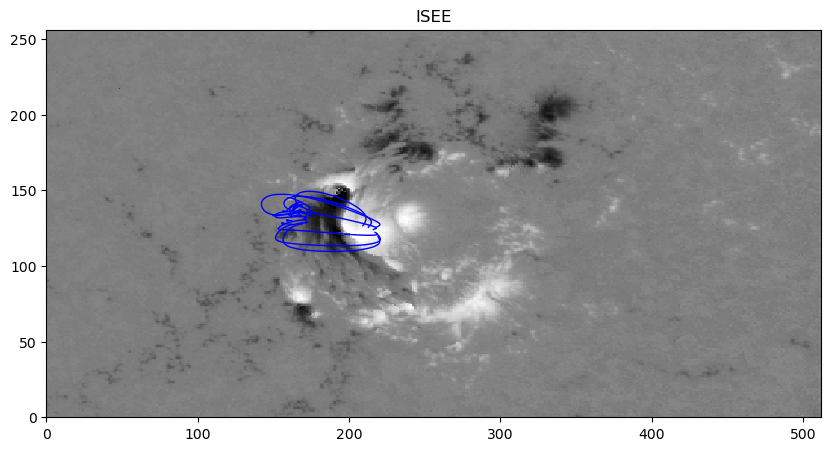

In [18]:
seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(B[..., 0, 2].T, cmap='gray', vmin=-2500, vmax=2500)
ax.set_aspect('equal')
ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("ISEE")
plt.show()